In [8]:
# In this notebook we develop methods to predict the expected errors of 
# Magnus expansion based piece-wise constant time evolution based pulse integration
# We present a method to estimate maximum errors, and determine step widths necessary 
# to achieve a target Infidelity (either for a pulse or merely for a single time-step)
# this allows adequately tailored unitary inteprolation grids to be constructed in such 
# a way, so as to not further limit the accuracy of an integration sheme

In [1]:
import numpy as np
from numpy.linalg import norm, eigh, qr
from scipy.linalg import schur

def Dag(U):
    return np.transpose(np.conj(U))

def vecxvec( E, wf, alpha): # Many times faster than multiply
    s = E.size
    for i in range(s):
        wf[i] = np.exp(-1j * E[i] * alpha) * wf[i]
    return wf
# Construct matrix exponentials and products faster than in numpy or scipy
def vm_exp_mul(E, V, dt = 1.0): # expm(diag(vector))*matrix  multiplication via exp(vector)*matrix
    s = E.size
    A = np.empty((s, s), np.complex128)
    for i in range(s):
        A[i,:] = np.exp(-1j * E[i] * dt) * Dag(V[:,i])
    return A
def expmH_from_Eig(E, V, dt = 1.0):
    U = np.dot(V, vm_exp_mul(E, V, dt))
    return U
def expmH(H, dt = 1.0):
    E, V = eigh(H)
    return expmH_from_Eig( E, V, dt)

In [16]:
# a function that takes an H_s object (Hamiltonian parts) and returns the constant time step approximation error
# takes the maximum rate of change for each field
def M1_Error(H_s, maxs, max_rates, t_step, t_max=None, mins=None):
    # Calculates the Infidelity (accuracy) of a M1 Magnus expansion (lowest order), by comparing with a M2 Magnus expansion (using cuommutators)
    # H_s contains the Hamiltonian parts [H0, H1, H2, ...] where H(t) = H0 + c1(t)*H1 + c2(t)*H2 + ...
    # for each ci(t) we construct a linear ramp function ci(t) = xi + yi*t where xi is in [mins[i], maxs[i]] and yi is in [-max_rates[i], max_rates[i]]
    # for a pulse max_rates may be given by max_rates = maxs * 2 * np.pi * f_max
    # tries to estimate a maximum error causing combination of parameters by alternating increasing and decreasing terms so that the functions don't cancel out
    # t_step is the time step used in the simulation
    # t_max is the total time of the simulation (if not set, will be equal to t_step) -> used to calculate the cummulative error of multiple steps
    if t_max is None:
        t_max = t_step
    t = t_step
    n_steps = int(t_max/t_step)
    if mins is None:
        mins = -maxs
    # construct commutators
    def commutator(Hi, Hj):
        return Hi @ Hj - Hj @ Hi
    def param(i, do_max_i, mins, maxs, max_rates):
        if do_max_i[i] == 1:
            xi, yi = maxs[i], -max_rates[i]
        else:
            xi, yi = mins[i], max_rates[i]
        return xi, yi
    H0 = H_s[0]
    Hi = H_s[1:]
    n = len(Hi)
    s = H0.shape[0]
    # Construct a timestep using t  and the 1st order magnus correction
    H_magnus_first = np.zeros((s, s), dtype=np.complex128)
    do_max_i = [1 if i % 2 == 0 else -1 for i in range(n)]
    t3 = t**3
    for i in range(n):
        xi, yi = param(i, do_max_i, mins, maxs, max_rates)
        H_magnus_first += commutator(H0, Hi[i]) * t3 / 6 * (-yi)
        for j in range(i+1, n):
            xj, yj = param(j, do_max_i, mins, maxs, max_rates)
            H_magnus_first += commutator(Hi[i], Hi[j]) * t3 / 12 * ( -xi*yj + yi*xj ) # /12 * because 1/2 of magnus term, and 1/6 from the integrals
    # estimate error -> calculate exponential -> then infidelity
    U_magnus_first = expmH(H_magnus_first) 
    # calculate the matrix power using n_steps
    if n_steps > 1:
        U_magnus_first = np.linalg.matrix_power(U_magnus_first, n_steps)
    curr_tr = np.trace(U_magnus_first)
    I = s/(s+1)-1/(s*(s+1)) * np.abs(curr_tr)**2
    return I

# Generalize Magnus_1_Error to Magnus_2_Error, where we compare first order Magnus to second order Magnus errors
def M2_Error(H_s, maxs, max_rates, t_step, t_max=None, mins=None):
    # Calculates the Infidelity (accuracy) of a M2 Magnus expansion (using commutator terms), by comparing with a M3 Magnus expansion (using double commutator terms)
    # H_s contains the Hamiltonian parts [H0, H1, H2, ...] where H(t) = H0 + c1(t)*H1 + c2(t)*H2 + ...
    # for each ci(t) we construct a linear ramp function ci(t) = xi + yi*t where xi is in [mins[i], maxs[i]] and yi is in [-max_rates[i], max_rates[i]]
    # for a pulse max_rates may be given by max_rates = maxs * 2 * np.pi * f_max
    # tries to estimate a maximum error causing combination of parameters by alternating increasing and decreasing terms so that the functions don't cancel out
    # t_step is the time step used in the simulation
    # t_max is the total time of the simulation (if not set, will be equal to t_step) -> used to calculate the cummulative error of multiple steps
    # construct commutators
    if t_max is None:
        t_max = t_step
    t = t_step
    n_steps = int(t_max/t_step)
    if mins is None:
        mins = -maxs
    def commutator(Hi, Hj):
        return Hi @ Hj - Hj @ Hi
    def comm3(Hi, Hj, Hk):
        return commutator(Hi, commutator(Hj, Hk))
    def param(i, do_max_i, mins, maxs, max_rates):
        if do_max_i[i] == 1:
            xi, yi = maxs[i], -max_rates[i]
        else:
            xi, yi = mins[i], max_rates[i]
        return xi, yi
    H0 = H_s[0]
    Hi = H_s[1:]
    n = len(Hi)
    s = H0.shape[0]
    # Construct a timestep using t  and the 1st order magnus correction
    H_magnus_second = np.zeros((s, s), dtype=np.complex128)
    do_max_i = [1 if i % 2 == 0 else -1 for i in range(n)]
    t4 = t**4
    for i in range(n):
        xi, yi = param(i, do_max_i, mins, maxs, max_rates)
        H_magnus_second += comm3(H0, H0, Hi[i]) * t4 / 24 * (-yi)
        for j in range(n):
            xj, yj = param(j, do_max_i, mins, maxs, max_rates)
            if j > i:
                H_magnus_second += comm3(H0, Hi[i], Hi[j]) * t4 / 24 * ( -xi*yj + yi*xj ) 
            H_magnus_second += comm3(Hi[i], H0, Hi[j]) * t4 / 120 * yj * ( -4*t*yi - 5*xi )
            for k in range(j+1,n):
                xk, yk = param(k, do_max_i, mins, maxs, max_rates)
                H_magnus_second += comm3(Hi[i], Hi[j], Hi[k]) * t4 / 120 * ( 4*t*yi + 5*xi ) * ( -xj*yk + yj*xk )

    # estimate error -> calculate exponential -> then infidelity
    U_magnus_second = expmH(H_magnus_second) 
    curr_tr = np.trace(U_magnus_second)
    I = s/(s+1)-1/(s*(s+1)) * np.abs(curr_tr)**2
    return I

import Analysis_Code.discrete_quantum as dq
rng= np.random.default_rng(100)
n = 3
s = 16
H_s = dq.Random_parametric_Hamiltonian_gauss(n, s, sigmas=np.pi/2*np.array([1.0,0.025, 0.001]), rng=rng)
#mins = -np.ones(n)
maxs = np.ones(n)
f_max = 3.0
max_rates = maxs * 2 * np.pi * f_max
I_M1 = M1_Error(H_s, maxs, max_rates, t_step=0.1)
I_M2 = M2_Error(H_s, maxs, max_rates, t_step=0.1)
print('I_M1:',I_M1)
print('I_M2:', I_M2)
print('-'*50)
print('Ratio (I_M1/I_M2)', I_M1/I_M2)

I_M1: 6.885429826297695e-08
I_M2: 5.936814373441734e-10
--------------------------------------------------
Ratio (I_M1/I_M2) 115.97852641476514


In [18]:
# Parameter scan
# We scan for a range of values of t using log spacing
from Analysis_Code.iplots import *
from tqdm import tqdm
t_vals = np.logspace(-3, 0, 100)

n = 3
s = 16
#mins = -np.ones(n)
maxs = np.ones(n)
f_max = 3.0
max_rates = maxs * 2 * np.pi * f_max
rng = np.random.default_rng(100)

reps = 100
I_vals_M1 = np.zeros((len(t_vals), reps))
I_vals_M2 = np.zeros((len(t_vals), reps))

for r in tqdm(range(reps)):
    H_s = dq.Random_parametric_Hamiltonian_gauss(n, s, sigmas=np.pi/2*np.array([1.0,0.025, 0.025]), rng=rng)
    for i, t in enumerate(t_vals):
        I_vals_M1[i, r] = M1_Error(H_s, maxs, max_rates, t_step=t)
        I_vals_M2[i, r] = M2_Error(H_s, maxs, max_rates, t_step=t)
# get mean and std
I_mean_M1 = np.mean(I_vals_M1, axis=1)
I_std_M1 = np.std(I_vals_M1, axis=1)
I_mean_M2 = np.mean(I_vals_M2, axis=1)
I_std_M2 = np.std(I_vals_M2, axis=1)

100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


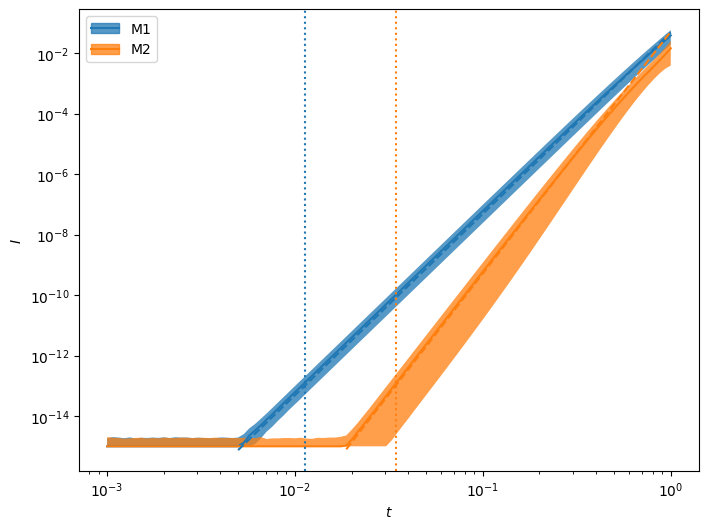

In [558]:
I_target = 10**-13
#### Estimate Step width for Target Fidelity using a 0th (1st order) order Magnus expansion #############################
# first we estimate the drift energies 
def Initial_t_step_from_H0(H_s, rotations=1/10):
    H0 = H_s[0]
    # get eigenvalues
    E0, _ = np.linalg.eigh(H0)
    max_dE = np.max(E0) - np.min(E0)
    max_df = max_dE / (2*np.pi)
    t_step = rotations / max_df
    return t_step
def Magnus_target_t_step(I_tar, I_t_step, t0, n=6):
    # Calculate the target t_step for a given target fidelity I_tar, given the fidelity at t_step I_t_step
    # for M1, n=6, for M2, n=8
    return (I_target/I_t_step)**(1/n) * t_step
def Magnus_Infidelity_fun(t, I_t_step, t_step, n=6):
    # construct the expected infidelity of a Magnus expansion with step width t, from a single value I_t_step with t_step
    # use n=6 for M1 and n=8 for M2
    return I_t_step * (t/t_step)**n

# get M1 and M2 values at t_step
t_step = Initial_t_step_from_H0(H_s)
#print(t_step)
I_M1_t_step = M1_Error(H_s, mins, maxs, max_rates, t=t_step)
I_M2_t_step = M2_Error(H_s, mins, maxs, max_rates, t=t_step)
# Error can be estimated as Is*t**n , with n=6 for M1 and n=8 for M2

t_target_M1 = Magnus_target_t_step(I_target, I_M1_t_step, t_step, n=6)
t_target_M2 = Magnus_target_t_step(I_target, I_M2_t_step, t_step, n=8) 
#print(t_target_M1, t_target_M2)

# plot with min_mean_max_plot from iplots
fig, ax1 = plt.subplots(figsize=(8,6))
legendary=[]
legendary, _ = min_mean_max_plot(ax1, t_vals, [I_mean_M1], [I_mean_M1-I_std_M1], [I_mean_M1+I_std_M1], ps=0.68, label=r'M1', legendary=legendary, support=[10**-15,1.0])
legendary, _ = min_mean_max_plot(ax1, t_vals, [I_mean_M2], [I_mean_M2-I_std_M2], [I_mean_M2+I_std_M2], ps=0.68, label=r'M2', legendary=legendary, support=[10**-15,1.0])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$I$')
# plot Infidelity fun
inds = np.where(I_mean_M1 > 10**-15)[0]
ts_M1 = t_vals[inds]
inds = np.where(I_mean_M2 > 10**-15)[0]
ts_M2 = t_vals[inds]
# M1
ax1.plot(ts_M1, Magnus_Infidelity_fun(ts_M1, I_M1_t_step, t_step, n=6), color='C0', linestyle='--', label=r'$\mathcal{O}(t^6)$')
ax1.plot(ts_M2, Magnus_Infidelity_fun(ts_M2, I_M2_t_step, t_step, n=8), color='C1', linestyle='--', label=r'$\mathcal{O}(t^8)$')
# two vertical lines at the t_target_M1 and t_target_M2 values
ax1.axvline(t_target_M1, color='C0', linestyle=':')
ax1.axvline(t_target_M2, color='C1', linestyle=':')
ax1.legend(*legendary)

In [ ]:
# Calculate the Ratio to a target infidelity as a function of the control field amplitudes


In [ ]:
# for a given set of frequencies f and maximum amplitudes a_max for a pulse p(t) in [-a_max, a_max] and p(t) = sum_{i=1}^n c_i*sin(2*pi*f_i*t + phi_i)
# the max ramp is given by (using f_max = max(f)): a_max * f_max * 2*pi

In [11]:
#####  Symbolic Python To Derive the Equations needed for the Error  #######################
#####  Analysis of M1 and M2 Magnus expansions (by expanding one order further)  ###########

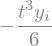

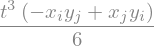

In [12]:
# use sympy to construct functions and commutators of them
import sympy as sp
from sympy import init_printing
init_printing() 
# ci(s) = xi + s * yi + s^2/2 * zi
# cj(s) = xj + s * yj + s^2/2 * zj
# then calculate: ci(s2)-ci(s1) and ci(s1)*cj(s2)-cj(s1)*ci(s2)
# define the symbols
s1, s2, xi, yi, xj, yj, t = sp.symbols('s_1 s_2 x_i y_i x_j y_j t')
# define lambda functions using sympy
ci = lambda s: xi + s * yi 
cj = lambda s: xj + s * yj 
#### First Order Magnus #######################################################
first_term = ci(s2)-ci(s1) #+ cj(s2)-cj(s1)
second_term = ci(s1)*cj(s2)-cj(s1)*ci(s2)
# simplify terms 
first_term  = sp.simplify(sp.collect(first_term, [yi, yj]))
second_term = sp.simplify(sp.collect(sp.expand(second_term), [xi*yj, xj*yi]))
# integrate terms with integrals int_0^t ds_1 int_0^s_1 ds_2 term
# first term
first_term_int  = sp.simplify(sp.collect(sp.integrate(sp.integrate(first_term, (s2, 0, s1)), (s1, 0, t)), t**3))
second_term_int = sp.simplify(sp.collect(sp.integrate(sp.integrate(second_term, (s2, 0, s1)), (s1, 0, t)), t**3))
display(first_term_int)
display(second_term_int)

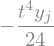

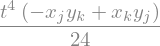

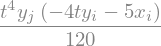

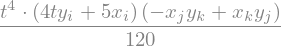

In [13]:
#### Second Order Magnus ######################################################
s1, s2, s3, xi, yi, xj, yj, xk, yk, t = sp.symbols('s_1 s_2 s_3 x_i y_i x_j y_j x_k y_k t')
# define lambda functions using sympy
ci = lambda s: xi + s * yi 
cj = lambda s: xj + s * yj 
ck = lambda s: xk + s * yk 
first_term  = cj(s3)-cj(s2) #+ ck(s3)-ck(s2)
second_term = cj(s2)*ck(s3)-ck(s2)*cj(s3)
third_term  = ci(s1) * first_term
fourth_term = ci(s1) * second_term
# simplify terms 
first_term  = sp.simplify(sp.collect(first_term, [yj, yk]))
second_term = sp.simplify(sp.collect(sp.expand(second_term), [xj*yk, xk*yj]))
third_term = sp.simplify(sp.collect(sp.expand(third_term), [xi*yj, xi*yk, yi*yj, yi*yk]))
fourth_term = sp.simplify(sp.collect(sp.expand(fourth_term), [xj*yk, xk*yj, xi*xj*yk, xi*xk*yj]))
# integrate terms with integrals int_0^t ds_1 int_0^s_1 ds_2 term
# first term
def magnus_2_integral(term):
    return sp.simplify(sp.collect(sp.integrate(sp.integrate(sp.integrate(term, (s3, 0, s2)), (s2, 0, s1)), (s1, 0, t)), t))
first_term_int  = magnus_2_integral(first_term)
second_term_int = magnus_2_integral(second_term)
third_term_int  = magnus_2_integral(third_term)
fourth_term_int = magnus_2_integral(fourth_term)
# print the terms using display latex
display(first_term_int)
display(second_term_int)
display(third_term_int)
display(fourth_term_int)